In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl

mpl.rcParams['font.size'] = 13

In [2]:
base_path = r"C:\Users\jorge\Documents\GitHub\Telecontrol_r\PowerSmoothing"
resultados_path = os.path.join(base_path, 'ps_data')

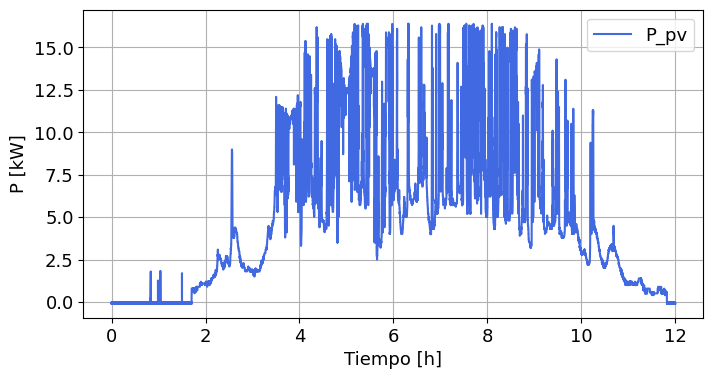

In [3]:
data_path = os.path.join(resultados_path, 'FV.txt')

with open(data_path, 'r') as file:
    # Lee todas las líneas y las almacena en una lista
    lines = file.readlines()

# Convierte las líneas en valores flotantes y almacénalos en una lista
values = [float(line.strip()) for line in lines]

# Crea el DataFrame con una columna llamada 'values'
df_data = pd.DataFrame(values, columns=['P_pv'])
df_data['Tiempo [h]'] = (df_data.index.to_numpy()) / 36000



df = df_data

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df['Tiempo [h]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)

# Añadir etiquetas y título
plt.xlabel("Tiempo [h]")
plt.ylabel("P [kW]")

# Añadir leyenda
plt.legend(loc='best')

# Mostrar la gráfica
plt.grid(True)
plt.show()

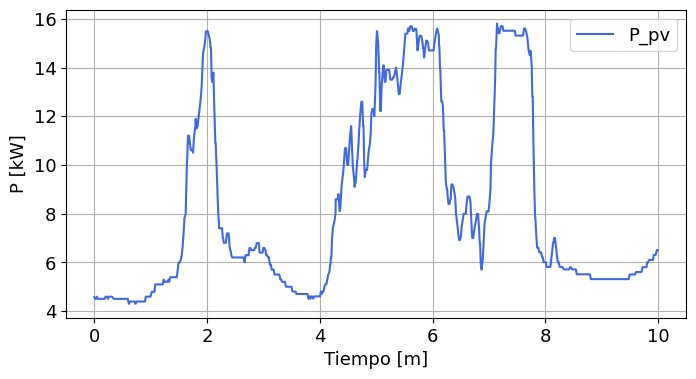

In [4]:
# df_data['Tiempo [h]'] = (df_data.index.to_numpy()) / 36000
df = df_data.iloc[164078:170078]
df = df.reset_index(drop=True)
df['Tiempo [m]'] = (df.index.to_numpy()) / 600

df_data_2 = df

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df['Tiempo [m]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)

# Añadir etiquetas y título
plt.xlabel("Tiempo [m]")
plt.ylabel("P [kW]")

# Añadir leyenda
plt.legend(loc='best')

# Mostrar la gráfica
plt.grid(True)
plt.show()

# Función df

In [5]:
def create_df(P_res_array, P_sc_array, P_pv_array):
    # Verificar que los arrays tengan la misma longitud
    if len(P_res_array) == len(P_sc_array) == len(P_pv_array):
        # Crear el DataFrame
        df = pd.DataFrame({
            'P_resultante': P_res_array,
            'P_sc': P_sc_array,
            'P_pv': P_pv_array
        })
    else:
        print("Los arrays no tienen la misma longitud")
    return df

# Función Gráfico

In [6]:
def graph_min(df, name):
    df['Tiempo [m]'] = (df.index.to_numpy()) / 600
    
    # Crear la gráfica
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.lineplot(x=df['Tiempo [m]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)
    sns.lineplot(x=df['Tiempo [m]'], y=df['P_sc'], color='mediumseagreen', linestyle='-', label = 'P_sc', ax=ax)
    sns.lineplot(x=df['Tiempo [m]'], y=df['P_resultante'], color='red', linestyle='-', label = 'P_resultante', ax=ax)
    
    # Añadir etiquetas y título
    plt.xlabel("Tiempo [m]")
    plt.ylabel("P [kW]")
    
    # Añadir leyenda
    plt.legend(loc='best')
    
    plt.grid(True)
    
    # Guardar la figura
    output_path = name + ".pdf"
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    
    plt.show()

# Función Análisis

In [7]:
def analysis(df):
    # Mostrar la varianza
    v_sin_PS = round(df['P_pv'].var(),2)
    v_con_PS = round(df['P_resultante'].var(),2)
    red = round((v_sin_PS-v_con_PS)*100/v_sin_PS,2)
    print(f"Varianza sin PS: {v_sin_PS}")
    print(f"Varianza con PS: {v_con_PS}")
    print(f"Reducción de Varianza: {red} %")
    # Calcular la energía
    intervalo_tiempo = 100 / 1000  # 0.1 segundos
    energia = round((df['P_pv'].sum() * intervalo_tiempo)/3600 , 3)
    print(f"Energía de P_pv: {energia} Wh")
    energia_ps = round((df['P_resultante'].sum() * intervalo_tiempo)/3600 , 3)
    print(f"Energía de P_resultante: {energia_ps} Wh")
    print(f"Diferencia de energía: {round(energia-energia_ps,3)} Wh")

# Función Control

In [8]:
def control(selected_control):       
    global P_pvc  # Declarar como global
    global P_cov
    global a_Butterworth
    global b_Butterworth
    global x_prev
    global y_prev
    if selected_control == 'RR Method':
        P_sc, P_pvc = control_rr(data_array, P_pvc, SOC, rampa_base)
        P_res = P_sc + P_pv
    elif selected_control == 'Exponential Method':
        P_sc, P_pvc = control_e(data_array, P_pvc, SOC, alpha)
        P_res = P_sc + P_pv
    elif selected_control == 'Staggered Method':
        P_sc, P_pvc = control_staggered(data_array, P_pvc, SOC, rampa_base, factor_dinamico)
        P_res = P_sc + P_pv
    elif selected_control == 'Kalman Filter':
        P_sc, P_pvc, P_cov = control_Kalman(data_array, P_pvc, SOC, P_cov)
        P_res = P_sc + P_pv
    elif selected_control == 'Kalman Exponential':
        P_sc, P_pvc, P_cov = control_Kalman_Exponential(data_array, P_pvc, SOC, P_cov)
        P_res = P_sc + P_pv
    elif selected_control == 'Butterworth Filter':
        P_sc, P_pvc, a_Butterworth, b_Butterworth, x_prev, y_prev = control_Butterworth(data_array, P_pvc, SOC, a_Butterworth, b_Butterworth, x_prev, y_prev)
        P_res = P_sc + P_pv
    else:
        print("Seleccion no válida")
        
    P_res_array.append(P_res) 
    P_sc_array.append(P_sc)
    P_pv_array.append(P_pv)

# General Methods

In [9]:
from func1 import *

In [10]:
window_c1 = 3
SOC = 50

## 1 Exponential Method

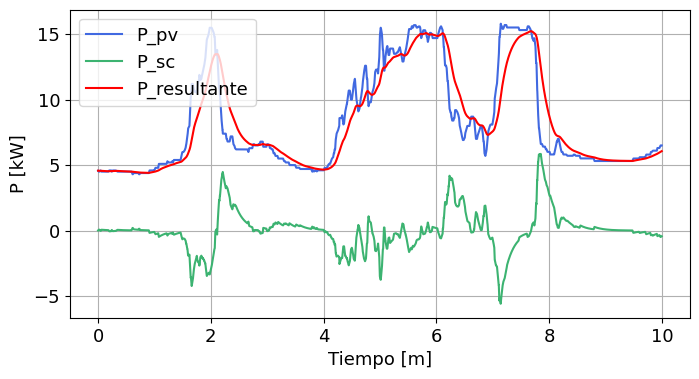

Varianza sin PS: 14.73
Varianza con PS: 12.6
Reducción de Varianza: 14.46 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.372 Wh
Diferencia de energía: 0.004 Wh


In [11]:
selected_control = 'Exponential Method'

alpha = 0.01
P_pvc = 4.57 # OJO se recalcula
data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, '1.' + selected_control + ' simulated')
analysis(df)

In [12]:
df

,P_resultante,P_sc,P_pv,Tiempo [m]
0,4.570000,-0.000050,4.57005,0.000000
1,4.569906,0.009336,4.56057,0.001667
2,4.569718,0.018618,4.55110,0.003333
3,4.569437,0.027807,4.54163,0.005000
4,4.569064,0.036914,4.53215,0.006667
...,...,...,...,...
5995,6.045866,-0.454134,6.50000,9.991667
5996,6.050407,-0.449593,6.50000,9.993333
5997,6.054903,-0.445097,6.50000,9.995000
5998,6.059354,-0.440646,6.50000,9.996667


## 2 RR Method

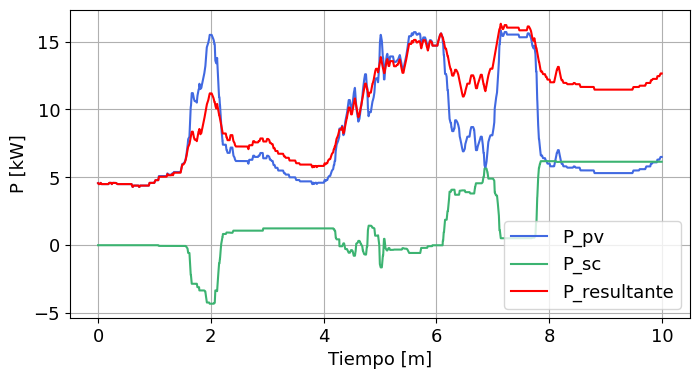

Varianza sin PS: 14.73
Varianza con PS: 12.83
Reducción de Varianza: 12.9 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.679 Wh
Diferencia de energía: -0.303 Wh


In [13]:
selected_control = 'RR Method'

P_pvc = 4.57 # OJO se recalcula
rampa_base = 0.04
data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, '2.' + selected_control + ' simulated')
analysis(df)

## 3 Staggered Method

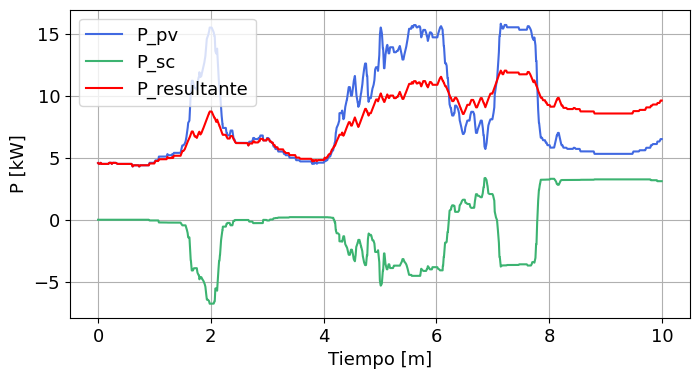

Varianza sin PS: 14.73
Varianza con PS: 5.27
Reducción de Varianza: 64.22 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.319 Wh
Diferencia de energía: 0.057 Wh


In [14]:
selected_control = 'Staggered Method'

P_pvc = 4.57 # OJO se recalcula
rampa_base = 0.02
factor_dinamico = 0.02
data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, '3.' + selected_control + ' simulated')
analysis(df)

In [15]:
# df

In [16]:
# csv_file_path = 'output.csv'  # Ruta y nombre del archivo CSV
# df.to_csv(csv_file_path, index=True)

## 4 Kalman filter

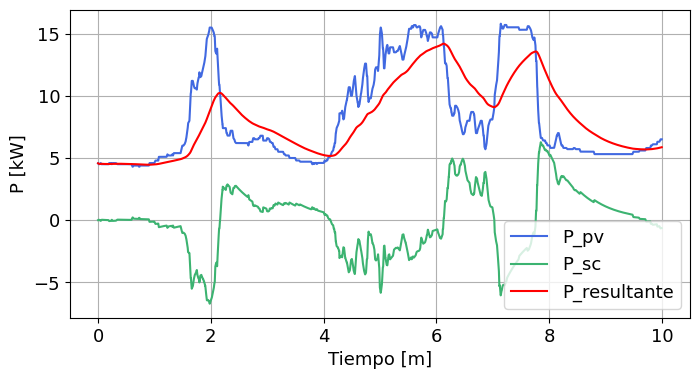

Varianza sin PS: 14.73
Varianza con PS: 8.62
Reducción de Varianza: 41.48 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.364 Wh
Diferencia de energía: 0.012 Wh


In [17]:
selected_control = 'Kalman Filter'

P_pvc = 4.57 # OJO se recalcula
P_cov = 1
data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, '4.' + selected_control + ' simulated')
analysis(df)

## 5 Kalman Exponential

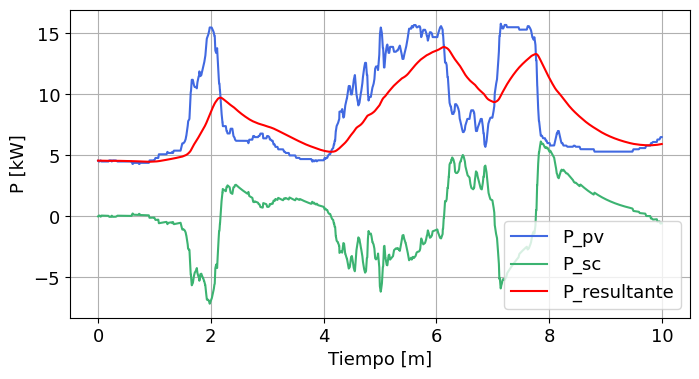

Varianza sin PS: 14.73
Varianza con PS: 8.0
Reducción de Varianza: 45.69 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.362 Wh
Diferencia de energía: 0.014 Wh


In [18]:
selected_control = 'Kalman Exponential'

P_pvc = 4.57 # OJO se recalcula
P_cov = 1
data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, '5.' + selected_control + ' simulated')
analysis(df)

## 6 Butterworth Filter

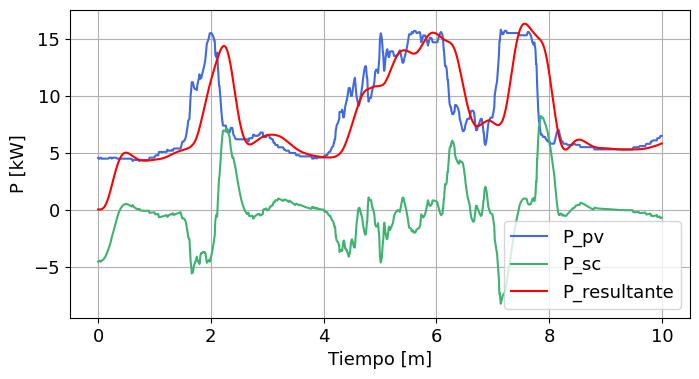

Varianza sin PS: 14.73
Varianza con PS: 15.57
Reducción de Varianza: -5.7 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.352 Wh
Diferencia de energía: 0.024 Wh


In [35]:
selected_control = 'Butterworth Filter'

P_pvc = 4.57 # OJO se recalcula

# Variables Butterworth
a_Butterworth = np.array([1, -3.950744090477214, 5.853441719482108, -3.854633844371359, 0.951936338552047])
a_Butterworth = np.array([1,-3.983581258658520,5.950878429266698,-3.951012436572833,0.983715267510478])
b_Butterworth = np.array([7.699098914705779e-09, 3.079639565882312e-08, 4.619459348823468e-08, 3.079639565882312e-08, 7.699098914705779e-09])
b_Butterworth = np.array([9.661396633990794e-11,3.864558653596318e-10,5.796837980394477e-10,3.864558653596318e-10,9.661396633990794e-11])
x_prev = np.zeros(4)
y_prev = np.zeros(4)

data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, '6.' + selected_control + ' simulated')
analysis(df)

# Real Time

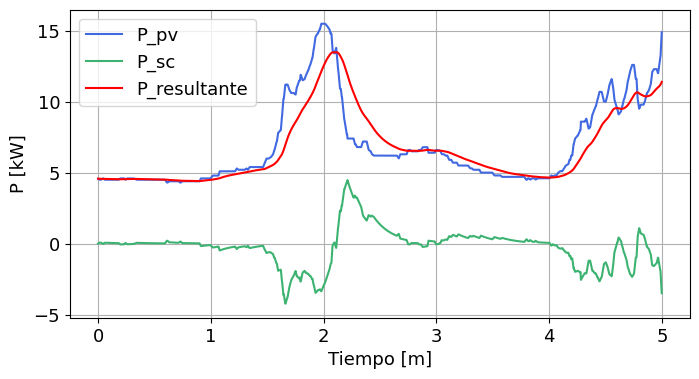

Varianza sin PS: 8.42
Varianza con PS: 6.09
Reducción de Varianza: 27.67 %
Energía de P_pv: 0.577 Wh
Energía de P_resultante: 0.558 Wh
Diferencia de energía: 0.019 Wh


In [20]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.1.exponential_simulated.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df
selected_control = 'Exponential Method'
graph_min(df, '1.' + selected_control + ' simulated_RealTime')
analysis(df)

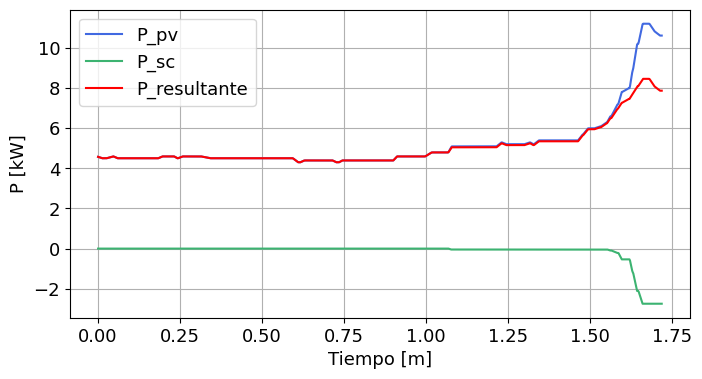

Varianza sin PS: 2.15
Varianza con PS: 0.93
Reducción de Varianza: 56.74 %
Energía de P_pv: 0.149 Wh
Energía de P_resultante: 0.144 Wh
Diferencia de energía: 0.005 Wh


In [21]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.3.staggered_simulated.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Staggered Method'
graph_min(df, '3.' + selected_control + ' simulated_RealTime')
analysis(df)

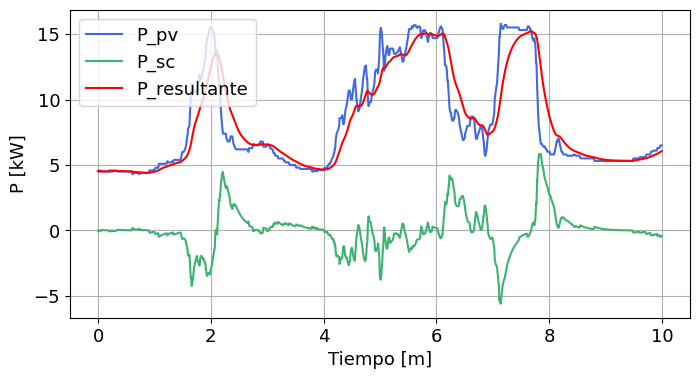

Varianza sin PS: 14.73
Varianza con PS: 12.59
Reducción de Varianza: 14.53 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.372 Wh
Diferencia de energía: 0.004 Wh


In [22]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.4.Kalman_simulated.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Kalman Filter'
graph_min(df, '4.' + selected_control + ' simulated_RealTime')
analysis(df)

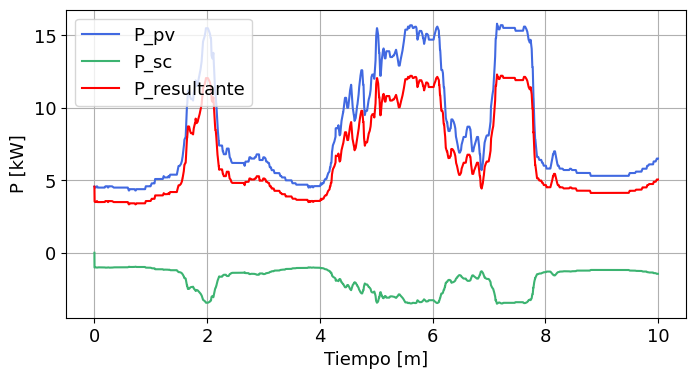

Varianza sin PS: 14.73
Varianza con PS: 8.91
Reducción de Varianza: 39.51 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.07 Wh
Diferencia de energía: 0.306 Wh


In [23]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.5.Wiener_simulated.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Wiener Filter'
graph_min(df, '5.' + selected_control + ' simulated_RealTime')
analysis(df)

In [24]:
# df = resultados_df

# df['Tiempo [h]'] = (df.index.to_numpy() + 164078) / 36000

# # Crear la gráfica
# fig, ax = plt.subplots(figsize=(8, 4))
# sns.lineplot(x=df['Tiempo [h]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)
# sns.lineplot(x=df['Tiempo [h]'], y=df['P_aux'], color='mediumseagreen', linestyle='-', label = 'P_aux', ax=ax)
# sns.lineplot(x=df['Tiempo [h]'], y=df['P_resultante'], color='red', linestyle='-', label = 'P_resultante', ax=ax)

# # Añadir etiquetas y título
# plt.xlabel("Tiempo [h]")
# plt.ylabel("P [W]")

# # Añadir leyenda
# plt.legend(loc='best')

# # Mostrar la gráfica
# plt.show()


In [25]:
# df = resultados_df

# # df['Tiempo [h]'] = (df.index.to_numpy() + 164078) / 36000
# df['Tiempo [m]'] = (df.index.to_numpy()) / 600

# # Crear la gráfica
# fig, ax = plt.subplots(figsize=(8, 4))
# sns.lineplot(x=df['Tiempo [m]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)
# sns.lineplot(x=df['Tiempo [m]'], y=df['P_sc'], color='mediumseagreen', linestyle='-', label = 'P_sc', ax=ax)
# sns.lineplot(x=df['Tiempo [m]'], y=df['P_resultante'], color='red', linestyle='-', label = 'P_resultante', ax=ax)

# # Añadir etiquetas y título
# plt.xlabel("Tiempo [m]")
# plt.ylabel("P [W]")

# # Añadir leyenda
# plt.legend(loc='best')

# # Mostrar la gráfica
# plt.show()

# Real

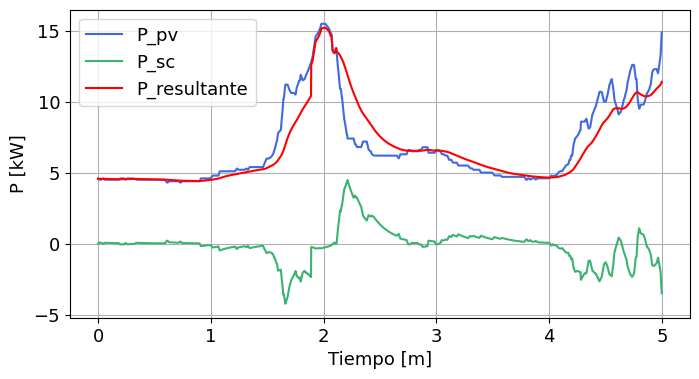

Varianza sin PS: 8.42
Varianza con PS: 7.28
Reducción de Varianza: 13.54 %
Energía de P_pv: 0.577 Wh
Energía de P_resultante: 0.566 Wh
Diferencia de energía: 0.011 Wh


In [26]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.1.exponential_real.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df
selected_control = 'Exponential Method'
graph_min(df, '1.' + selected_control + ' _RealTime')
analysis(df)

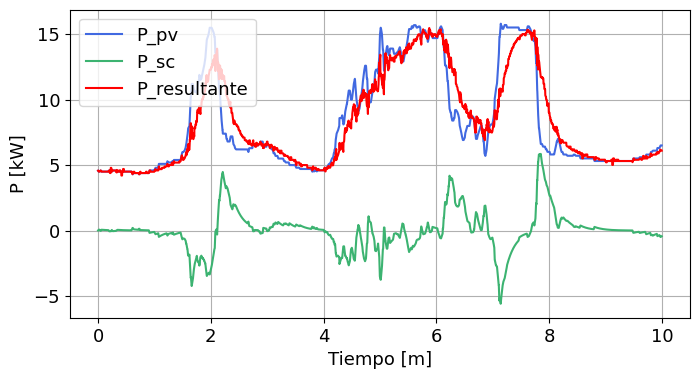

Varianza sin PS: 14.73
Varianza con PS: 12.36
Reducción de Varianza: 16.09 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.374 Wh
Diferencia de energía: 0.002 Wh


In [27]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.1.exponential_real_10m.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df
selected_control = 'Exponential Method'
graph_min(df, '1.' + selected_control + ' _RealTime')
analysis(df)

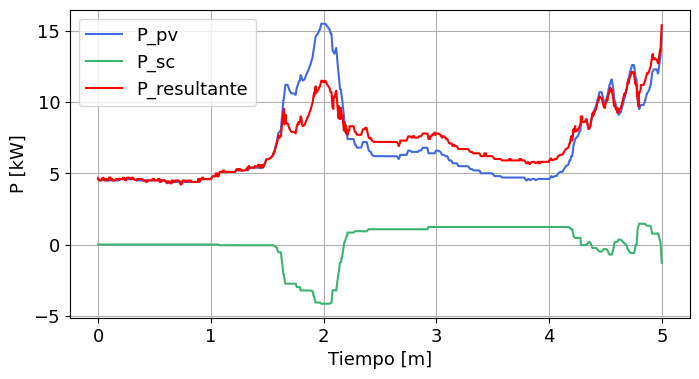

Varianza sin PS: 8.42
Varianza con PS: 4.94
Reducción de Varianza: 41.33 %
Energía de P_pv: 0.577 Wh
Energía de P_resultante: 0.59 Wh
Diferencia de energía: -0.013 Wh


In [28]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.3.staggered_real.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Staggered Method'
graph_min(df, '3.' + selected_control + ' _RealTime')
analysis(df)

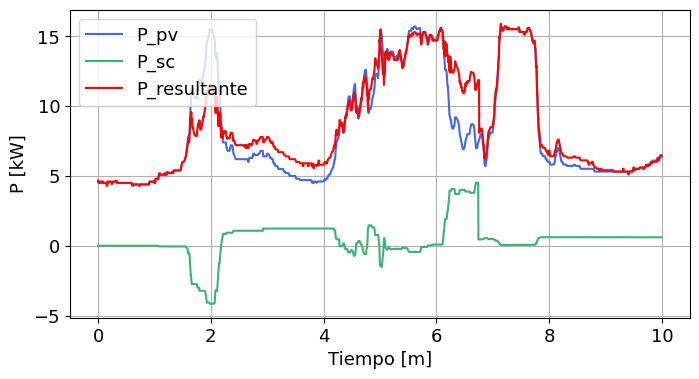

Varianza sin PS: 14.73
Varianza con PS: 13.14
Reducción de Varianza: 10.79 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.434 Wh
Diferencia de energía: -0.058 Wh


In [29]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.3.staggered_real_10m.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Staggered Method'
graph_min(df, '3.' + selected_control + ' _RealTime')
analysis(df)

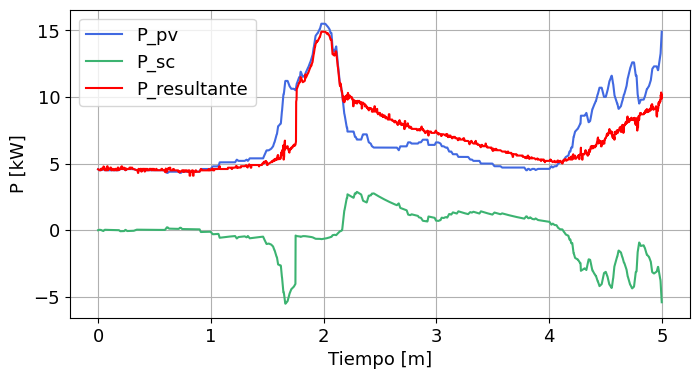

Varianza sin PS: 8.42
Varianza con PS: 5.94
Reducción de Varianza: 29.45 %
Energía de P_pv: 0.577 Wh
Energía de P_resultante: 0.564 Wh
Diferencia de energía: 0.013 Wh


In [30]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.4.Kalman_real.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Kalman Filter'
graph_min(df, '4.' + selected_control + ' _RealTime')
analysis(df)

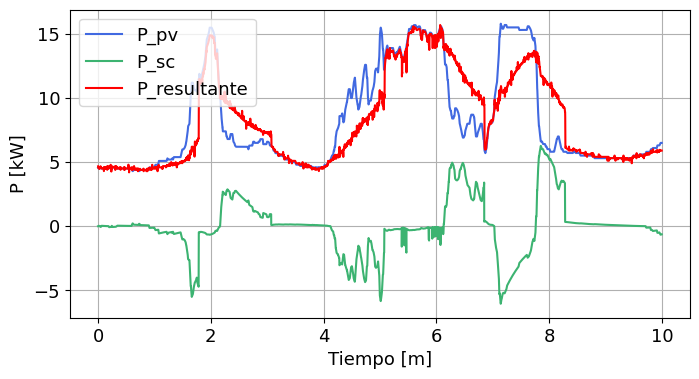

Varianza sin PS: 14.73
Varianza con PS: 12.44
Reducción de Varianza: 15.55 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.373 Wh
Diferencia de energía: 0.003 Wh


In [31]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.4.Kalman_real_2.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Kalman Filter'
graph_min(df, '4.' + selected_control + ' _RealTime')
analysis(df)

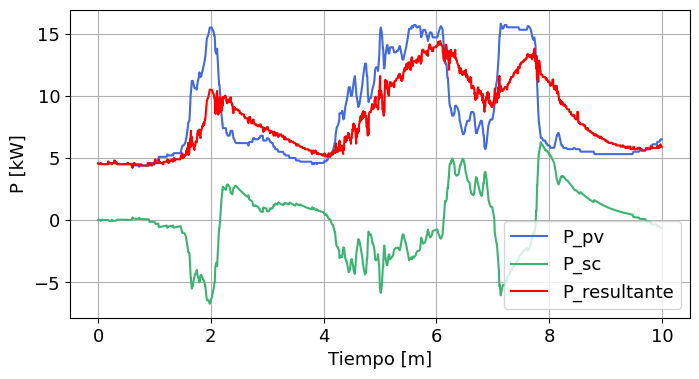

Varianza sin PS: 14.73
Varianza con PS: 8.4
Reducción de Varianza: 42.97 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.369 Wh
Diferencia de energía: 0.007 Wh


In [32]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.4.Kalman_real_10m.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Kalman Filter'
graph_min(df, '4.' + selected_control + ' _RealTime')
analysis(df)

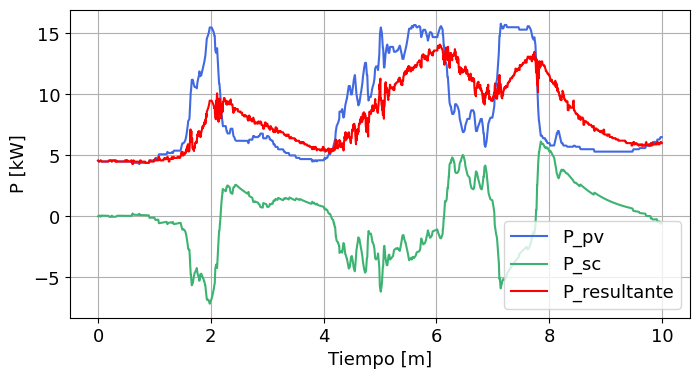

Varianza sin PS: 14.73
Varianza con PS: 7.88
Reducción de Varianza: 46.5 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.367 Wh
Diferencia de energía: 0.009 Wh


In [33]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.5.Kalman_Exponential_10m_2.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Kalman Exponential'
graph_min(df, '5.' + selected_control + ' _RealTime')
analysis(df)

In [34]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.5.Wiener_real.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Wiener Filter'
graph_min(df, '5.' + selected_control + ' _RealTime')
analysis(df)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jorge\\Documents\\GitHub\\Telecontrol_r\\PowerSmoothing\\ps_data\\resultados.5.Wiener_real.txt'